In [63]:
from __future__ import division
import numpy as np
from scipy.optimize import root, fsolve, broyden1
from functools import partial
import matplotlib.pyplot as plt
import pandas as pd

#defined for 2d use
def Dx(u,h):
  return np.diff(np.column_stack((u,u[:,0])))/h
def Dy(u,h):
  return np.diff(np.vstack((u,u[0])),axis=0)/h
def dx(u,h):  return np.diff(np.column_stack((u[:,-1],u)))/h
def dy(u,h):
  return np.diff(np.vstack((u[-1],u)),axis=0)/h
def Dh(u,h):
  return np.array([Dx(u,h),Dy(u,h)])
def dh(f,h):
  return dx(f[0],h) + dy(f[1],h)

class DLSSsolver2d():
  def __init__(self, k, h, scope, uinitial, steps = 1000, savesteps = [10]):
    self.h = h
    self.k = k
    self.x = np.linspace(scope[0,0]+h,scope[0,1],int((scope[0,1]-scope[0,0])/h)+1)
    self.y = np.linspace(scope[1,0]+h,scope[1,1],int((scope[1,1]-scope[1,0])/h)+1)
    self.gridpt = np.meshgrid(self.x,self.y)
    self.u0 = np.array([[uinitial([x,y]) for x in self.x] for y in self.y])
    self.u = self.u0
    self.uold = self.u0
    self.steps = steps
    if type(savesteps) == int:
      self.savesteps = range(0,steps,savesteps)
    else:
      self.savesteps = savesteps
    self.usol = [self.uold]
    self.tt = [0]
  def Nsch(self,u):
    u = u.reshape(self.u.shape)   
    H = -1/2*(Dx(u,self.h)**2/(u**2) + Dy(u,self.h)**2/(u**2))- dx(Dx(u,self.h)/u,self.h)-dy(Dy(u,self.h)/u,self.h)
    umiddlex = (np.roll(self.uold,-1)+self.uold)/2
    umiddley = (np.roll(self.uold,-1,axis=0)+self.uold)/2
    f = dx(umiddlex*Dx(H,self.h),self.h) + dy(umiddlex*Dy(H,self.h),self.h)
    return f.flatten()
  def forward_diff(self):
    self.uold = self.u
    self.u = self.u + self.k*self.Nsch()
  def explicit_implicit(self):
    self.uold = self.u
    # g = lambda u:(u - self.uold) - self.k* self.Nsch(u)
    # sol=root(g,self.uold,method='df-sane')
    g = lambda u: ((u - self.uold.flatten()) - self.k* self.Nsch(u))
    sol=root(g,self.uold.flatten(),method='krylov',options={'ftol':1e-5})#,method='lm',options={'xtol':1e-20})#,options={'ftol': 1e-100})#,method='df-sane')#,options={'ftol': 1e-20})
    self.u=sol.x.reshape(self.u.shape)
  def run(self,method):
    self.method = method
    for i in range(self.steps+1):
      if method == 'forward_diff':
        self.forward_diff()
      elif method == 'explicit_implicit':
        self.explicit_implicit()
      else:
        raise Exception('Method not defined!')
      if i in self.savesteps:
        print(i)
        self.usol.append(self.u)
        self.tt.append(self.k*self.steps)
    self.usol = np.array(self.usol)


In [99]:
m = 8
h = 0.01
k = 1e-6
steps = int(7.2e-4/k)
plttime =np.array([8e-6,3.2e-5,1e-4,7.2e-4])
savesteps = plttime/k
savesteps = [int(s) for s in savesteps]

def runsimulation(m,h,k,steps,savesteps):
  epsi = 1e-3
  u0_fun =  lambda x: (epsi**0.5 + ((1 + np.cos(2*np.pi*x[0])*np.cos(2*np.pi*x[1]))/2)**m)**2
  # u0_fun =  lambda x: (epsi**0.5 + ((1 + np.cos(2*np.pi*x[0]))/2)**m)**2
  # control of the run
  scope = np.array([[0,1],[0,1]])
  # build the model
  a = DLSSsolver2d(k,h,scope,u0_fun,steps,savesteps)
  a.run('explicit_implicit')
  return a.usol, a.x, a.tt


In [100]:
usol,x,t=runsimulation(m,h,k,steps,savesteps)

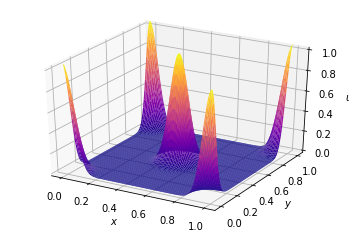

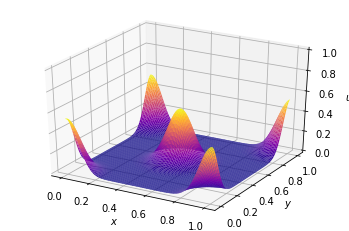

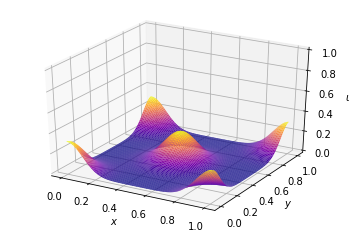

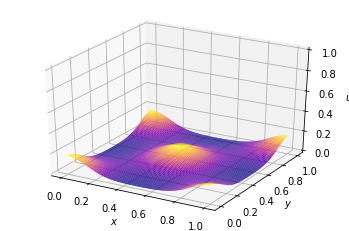

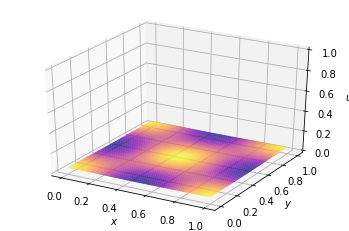

In [120]:
for i in range(len(usol)):
  fig=plt.figure()
  ax = fig.gca(projection='3d')
  xx = np.insert(x,0,0)
  [xx,yy]= np.meshgrid(xx,xx)
  ss = np.zeros(np.array(usol[0].shape)+np.array([1,1]))
  ss[1:,1:]=usol[i,:,:]
  ss[1:,0] = usol[i,:,-1]
  ss[0,:] = ss[-1,:]
  plt.xlabel(r'$x$')
  plt.ylabel(r'$y$')
  surf = ax.plot_surface(xx,yy,ss, lw=0.5, rstride=1, cstride=1,cmap='plasma')
  ax.set_zlabel(r'$u$')
  ax.set_zlim([0,1])


Text(0, 0.5, '$\\min$')

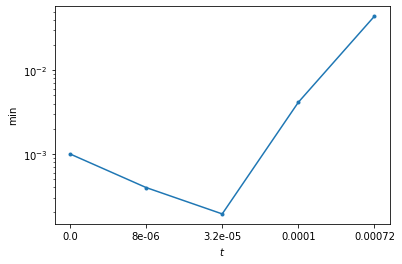

In [121]:
tt = np.insert(plttime,0,0)
plt.semilogy([(np.min(usol[i,:])) for i in range(usol.shape[0])],'.-')
# plt.plot(a.tt,[(np.min(a.usol[i,:,1])) for i in range(a.usol.shape[0])])
# plt.plot(a.tt,[(np.min(a.usol[i,:,2])) for i in range(a.usol.shape[0])])
axes = plt.gca()
t11 = [str(i) for i in tt]
plt.xticks(range(len(t11)), t11)
plt.xlabel(r'$t$')
plt.ylabel(r'$\min$')


Text(0, 0.5, '$F_h(u)$')

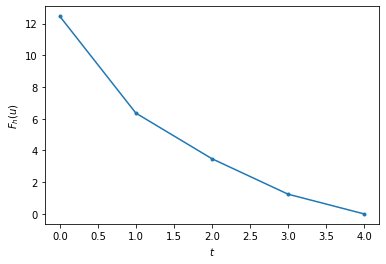

In [125]:
energyf = lambda u: h**2*np.sum(Dx(u,h)**2/u+Dy(u,h)**2/u)/2
plt.plot([energyf(usol[i,1:]) for i in range(len(usol))],'.-')
axes = plt.gca()
plt.xlabel(r'$t$')
plt.ylabel(r'$F_h(u)$')


In [126]:
hall = [1./10,1./20,1./40,1./80,1./160]
usolall=[]
xall=[]
for i in range(len(hall)):
  h=hall[i]
  k=1e-6
  steps = int(7.2e-4/k)
  plttime =np.array([1e-4, 7.2e-4])
  savesteps = plttime/k
  savesteps = [int(s) for s in savesteps]
  usol,x,t=runsimulation(1,h,k,steps,savesteps)
  usolall.append(usol[-1])
  xall.append(x)


In [128]:
from scipy.interpolate import interp2d
def nppad(usol):
  ss = np.zeros(np.array(usol.shape)+np.array([1,1]))
  ss[1:,1:]=usol[:,:]
  ss[1:,0] = usol[:,-1]
  ss[0,:] = ss[-1,:]
  return ss

def calerror(x,u,x_r,u_r):
	f = interp2d(x,x,u,"cubic")
	err = lambda x,y: np.sum((x-y)**2)
	return np.sqrt(err(f(x_r,x_r),u_r))
err = np.zeros(len(hall)-1)
for i in range(len(hall)-1):
  err[i]=calerror(np.insert(xall[i],0,0),nppad(usolall[i]),np.insert(xall[-1],0,0),nppad(usolall[-1]))

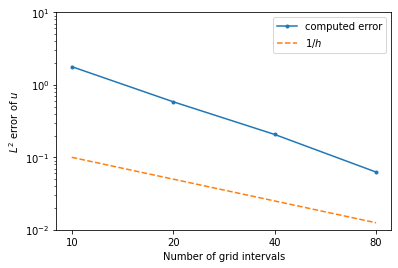

In [130]:
plt.semilogy(err,'.-')
plt.semilogy(np.array(hall[:-1]),'--')
plt.ylim([0.01,10])
xi = [str(i) for i in [10,20,40,80]]
plt.xticks(range(len(xi)), xi)
plt.xlabel('Number of grid intervals')
plt.ylabel(r'$L^2$'+' error of ' + r'$u$')
plt.legend(['computed error',r'$1/h$'])